In [2]:
# Import libraries
import os
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
from shapely.geometry import box
import geopandas as gpd
import earthpy as et

# Set working dir & get data NOTE: should already be there
# data = et.data.get_data('spatial-vector-lidar')
# source_folder = os.path.join(et.io.HOME, 'earth-analytics')
# destination_folder = os.path.join(os.getcwd(), 'data')
# os.rename(source_folder, destination_folder)

In [4]:
# Import data
data_path = os.path.join("data/data/spatial-vector-lidar")

country_bound_us = gpd.read_file(os.path.join(data_path, "usa", 
                                              "usa-boundary-dissolved.shp"))
                                 
state_bound_us = gpd.read_file(os.path.join(data_path, "usa", 
                                            "usa-states-census-2014.shp"))
                               
pop_places = gpd.read_file(os.path.join(data_path, "global", 
                                        "ne_110m_populated_places_simple", 
                                        "ne_110m_populated_places_simple.shp"))
                                        
ne_roads = gpd.read_file(os.path.join(data_path, "global", 
                                      "ne_10m_roads", "ne_10m_roads.shp"))

In [ ]:
# Simplify the country boundary just a little bit to make this run faster
country_bound_us_simp = country_bound_us.simplify(.2, preserve_topology=True)

# Clip the roads to the US boundary - this will take about a minute to execute
roads_cl = gpd.clip(ne_roads, country_bound_us_simp)
roads_cl.crs = ne_roads.crs

# Dissolve states by region
regions_agg = state_bound_us.dissolve(by="region", aggfunc="sum")

Just like you might do in ArcMap or QGIS you can perform spatial joins in Python too. A spatial join is when you append the attributes of one layer to another based upon its spatial relationship.

So - for example if you have a roads layer for the United States, and you want to apply the “region” attribute to every road that is spatially in a particular region, you would use a spatial join. To apply a join you can use the geopandas.sjoin() function as following:

`.sjoin(layer-to-add-region-to, region-polygon-layer)`

#### Sjoin Arguments:
The `op` argument specifies the type of join that will be applied

`intersects`: Returns True if the boundary and interior of the object intersect in any way with those of the other.

`within`: Returns True if the object’s boundary and interior intersect only with the interior of the other (not its boundary or exterior).

`contains`: Returns True if the object’s interior contains the boundary and interior of the other object and their boundaries do not touch at all.
You can read more about each type here.

How allows the following options: (this is taken directly from the geopandas code on github!

‘left’: use keys from left_df; retain only left_df geometry column
‘right’: use keys from right_df; retain only right_df geometry column
‘inner’: use intersection of keys from both dfs; retain only left_df geometry column

In [13]:
# Roads within region
roads_region = gpd.sjoin(
    roads_cl, 
    regions_agg, 
    how="inner", 
    op='intersects'
    )

# Notice once you have joins the data - you have attributes 
# from the regions_object (i.e. the region) attached to each road feature
roads_region[["featurecla", "index_right", "ALAND"]].head()

/home/tristannew/.cache/pypoetry/virtualenvs/earth-data-science-textbook-VbL9wLaR-py3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,featurecla,index_right,ALAND
2726,Road,Southeast,1364632039655
2725,Road,Southeast,1364632039655
4144,Road,Southeast,1364632039655
49423,Road,Southeast,1364632039655
2709,Road,Southeast,1364632039655


In [19]:
# Reproject to Albers for plotting
country_albers = country_bound_us.to_crs('epsg:5070')
roads_albers = roads_region.to_crs('epsg:5070')

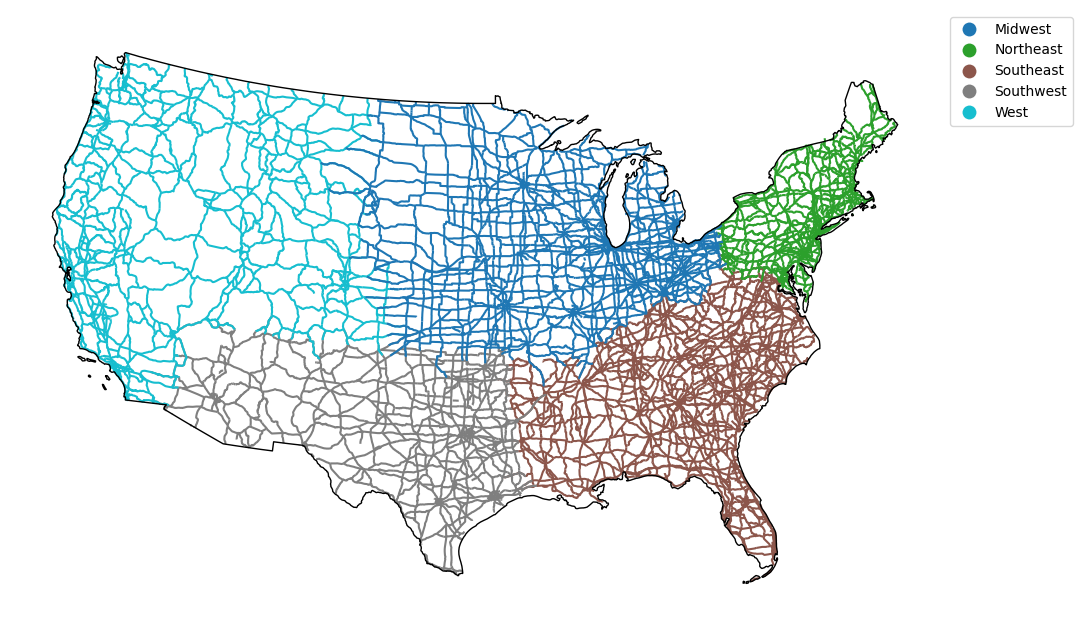

In [20]:
# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))

country_albers.plot(alpha=1,
                    facecolor="none",
                    edgecolor="black",
                    zorder=10,
                    ax=ax)

roads_albers.plot(column='index_right',
                  ax=ax,
                  legend=True)

# Adjust legend location
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.15,1))

ax.set_axis_off()
plt.axis('equal')
plt.show()

Below is a better customisation of the colors/legend, rather than just having a default pandas legend

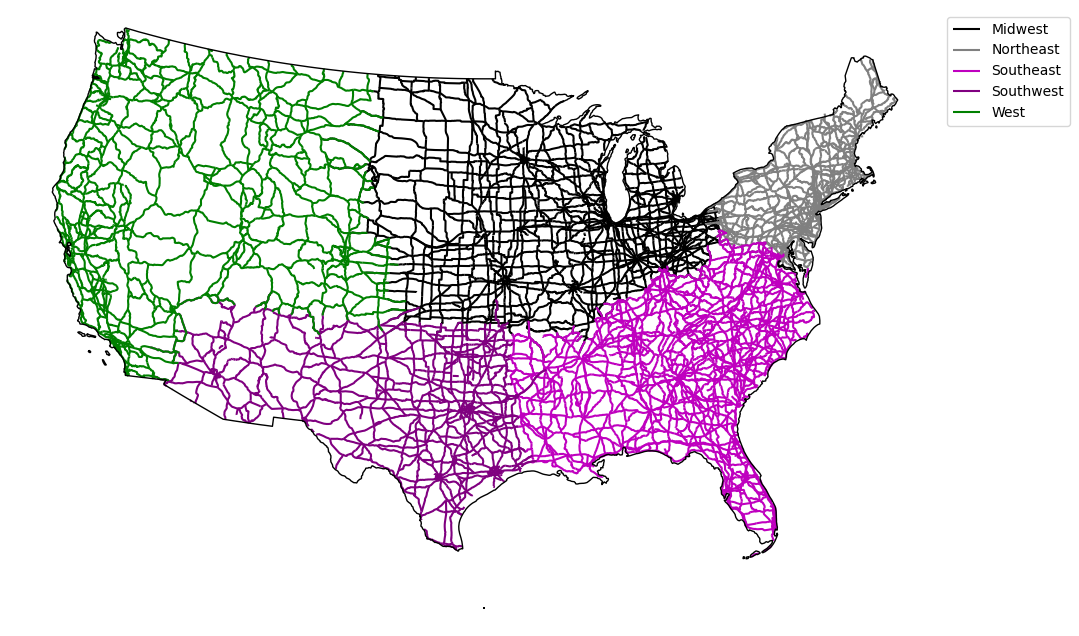

In [21]:
# First, create a dictionary with the attributes of each legend item
road_attrs = {'Midwest': ['black'],
              'Northeast': ['grey'],
              'Southeast': ['m'],
              'Southwest': ['purple'],
              'West': ['green']}

# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))

regions_agg.plot(edgecolor="black",
                 ax=ax)
country_albers.plot(alpha=1,
                    facecolor="none",
                    edgecolor="black",
                    zorder=10,
                    ax=ax)

for ctype, data in roads_albers.groupby('index_right'):
    data.plot(color=road_attrs[ctype][0],
              label=ctype,
              ax=ax)
    
# This approach works to place the legend when you have defined labels
plt.legend(bbox_to_anchor=(1.0, 1), loc=2)
ax.set_axis_off()
plt.axis('equal')
plt.show()

In [28]:
# Turn off scientific notation
pd.options.display.float_format = '{:.4f}'.format

# Calculate the total length of road 
road_albers_length = roads_albers[['index_right', 'length_km']]

# Sum existing columns
road_albers_length.groupby('index_right').sum()

roads_albers['rdlength'] = roads_albers.length
sub = roads_albers[['rdlength', 'index_right']].groupby('index_right').sum()
sub

,rdlength
index_right,
Midwest,86575020.6373
Northeast,33786036.8608
Southeast,84343077.8904
Southwest,49373104.8209
West,61379830.5534
